# Binary Class Image Classification Deep Learning Model for CycleGAN Cezanne vs. Photo Using TensorFlow Take 1
### David Lowe
### September 20, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The CycleGAN Cezanne vs. Photo dataset is a binary classification situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: The CycleGAN dataset collection contains images from two classes A and B (for example, apple vs. orange, horses vs. zebras, and so on). The researchers used the images to train machine learning models for research work in General Adversarial Networks (GAN).

In this iteration, we will construct a CNN model based on the InceptionV3 architecture to make predictions.

ANALYSIS: In this iteration, the InceptionV3 model's performance achieved an accuracy score of 99.65% after ten epochs using the training dataset. The same model processed the validation dataset with an accuracy measurement of 98.24%. Finally, the final model processed the test dataset with an accuracy score of 99.75%.

CONCLUSION: In this iteration, the InceptionV3-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: CycleGAN Cezanne vs. Photo Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/

One potential source of performance benchmarks: https://arxiv.org/abs/1703.10593 or https://junyanz.github.io/CycleGAN/

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Sep 20 17:57:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 10
BATCH_SIZE = 16
# RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (299, 299)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 1  # 1 for binary classification
CLASS_LABELS = ['Cezanne','Photo']
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/train/'
# VALID_DIR = ''
TEST_DIR = 'staging/test/'
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Number of GPUs detected by TensorFlow:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Number of GPUs detected by TensorFlow: 1
TensorFlow version: 2.6.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
!rm -rf staging/
!mkdir staging/
dataset_zip = 'cezanne2photo.zip'
if not os.path.exists(dataset_zip):
    !wget https://dainesanalytics.com/datasets/tensorflow-taesungpark-cyclegan-datasets/cezanne2photo.zip

In [14]:
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [15]:
!mkdir -v staging/train
!mkdir -v staging/test
!mv staging/cezanne2photo/trainA/ staging/train/Cezanne/
!mv staging/cezanne2photo/trainB/ staging/train/Photo/
!mv staging/cezanne2photo/testA/ staging/test/Cezanne/
!mv staging/cezanne2photo/testB/ staging/test/Photo/

mkdir: created directory 'staging/train'
mkdir: created directory 'staging/test'


In [16]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5])

Number of training images for Cezanne : 525
Training samples for Cezanne : ['00337.jpg', '00242.jpg', '00441.jpg', '00305.jpg', '00568.jpg']
Number of training images for Photo : 6287
Training samples for Photo : ['2015-07-03 10:09:55.jpg', '2015-11-13 16:19:17.jpg', '2015-03-15 23:15:56.jpg', '2016-12-05 17:48:13.jpg', '2015-02-27 03:43:12.jpg']


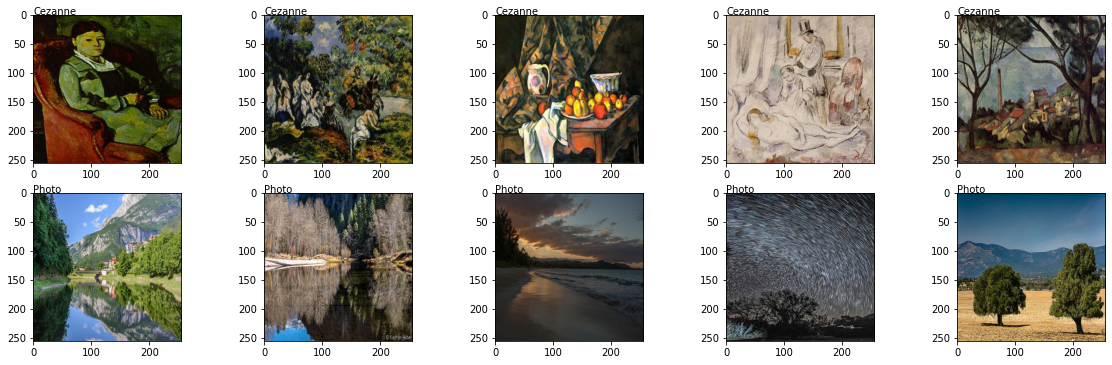

In [17]:
# Plot some training images from the dataset
nrows = 2
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(c_label+'/'+training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [18]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 5450 images belonging to 2 classes.
Number of training image batches per epoch of modeling: 341
Loading and pre-processing the validation images...
Found 1362 images belonging to 2 classes.
Number of validation image batches per epoch of modeling: 86


In [19]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [20]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [21]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [22]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [23]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
reset_random()
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
341/341 [==============================] - 163s 444ms/step - loss: 0.4885 - accuracy: 0.9839 - val_loss: 0.0430 - val_accuracy: 0.9912
Epoch 2/10
341/341 [==============================] - 145s 423ms/step - loss: 0.0352 - accuracy: 0.9925 - val_loss: 0.0348 - val_accuracy: 0.9956
Epoch 3/10
341/341 [==============================] - 144s 421ms/step - loss: 0.0507 - accuracy: 0.9917 - val_loss: 0.0216 - val_accuracy: 0.9971
Epoch 4/10
341/341 [==============================] - 143s 418ms/step - loss: 0.0196 - accuracy: 0.9932 - val_loss: 0.0020 - val_accuracy: 0.9993
Epoch 5/10
341/341 [==============================] - 143s 418ms/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.0083 - val_accuracy: 0.9985
Epoch 6/10
341/341 [==============================] - 142s 417ms/step - loss: 0.0415 - accuracy: 0.9901 - val_loss: 0.6084 - val_accuracy: 0.9684
Epoch 7/10
341/341 [==============================] - 142s 417ms/step - loss: 0.0164 - accuracy: 0.9965 - val_loss: 0.0209 -

In [24]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              268437504 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 290,242,337
Trainable params: 290,207,905
Non-trainable params: 34,432
_________________________________________________________________


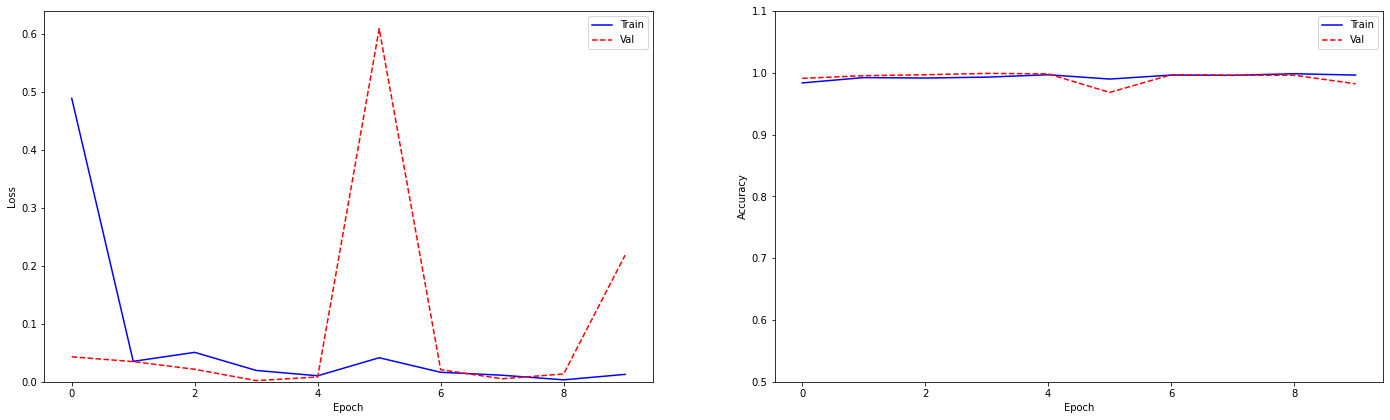

In [25]:
plot_metrics(nn_model_history)

In [26]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [27]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Not applicable for this iteration of modeling

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
datagen_kwargs = dict(rescale=1./255)
train_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="binary")

do_data_augmentation = True
if do_data_augmentation:
    train_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(train_generator))

Loading and pre-processing the training images...
Found 6812 images belonging to 2 classes.
Number of training image batches per epoch of modeling: 426


In [32]:
# Prepare the final neural network model
start_time_module = datetime.now()
reset_random()
final_model = create_nn_model()
final_model.fit(train_generator, epochs=MAX_EPOCHS, verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
426/426 [==============================] - 183s 414ms/step - loss: 1.5363 - accuracy: 0.9624
Epoch 2/10
426/426 [==============================] - 173s 406ms/step - loss: 0.0340 - accuracy: 0.9885
Epoch 3/10
426/426 [==============================] - 173s 406ms/step - loss: 0.2181 - accuracy: 0.9877
Epoch 4/10
426/426 [==============================] - 173s 405ms/step - loss: 0.0251 - accuracy: 0.9921
Epoch 5/10
426/426 [==============================] - 174s 408ms/step - loss: 0.0183 - accuracy: 0.9940
Epoch 6/10
426/426 [==============================] - 174s 408ms/step - loss: 0.0345 - accuracy: 0.9950
Epoch 7/10
426/426 [==============================] - 173s 406ms/step - loss: 0.0095 - accuracy: 0.9966
Epoch 8/10
426/426 [==============================] - 173s 406ms/step - loss: 0.0076 - accuracy: 0.9971
Epoch 9/10
426/426 [==============================] - 173s 407ms/step - loss: 0.0182 - accuracy: 0.9956
Epoch 10/10
426/426 [==============================] - 174s 407m

In [33]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              268437504 
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 290,242,337
Trainable params: 290,207,905
Non-trainable params: 34,432
_________________________________________________________________


In [34]:
print('Loading and pre-processing the testing images...')
test_datagen = ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                  target_size=TARGET_IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the testing images...
Found 809 images belonging to 2 classes.
Number of image batches per epoch of modeling: 51


In [35]:
final_model.evaluate(test_generator, verbose=1)

51/51 [==============================] - 6s 98ms/step - loss: 0.0066 - accuracy: 0.9975


[0.006582218687981367, 0.9975278377532959]

In [36]:
test_predictions = (final_model.predict(test_generator) > 0.5).astype('int').ravel()
test_originals = test_generator.labels
print('Accuracy Score:', accuracy_score(test_originals, test_predictions))
print(confusion_matrix(test_originals, test_predictions))
print(classification_report(test_originals, test_predictions))

Accuracy Score: 0.9975278121137207
[[ 56   2]
 [  0 751]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        58
           1       1.00      1.00      1.00       751

    accuracy                           1.00       809
   macro avg       1.00      0.98      0.99       809
weighted avg       1.00      1.00      1.00       809



In [37]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [38]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:53:40.078047
